## Import Library

In [1]:
# Import some libraries

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')
import statistics

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## Initialize Data

In [2]:
data_komentar = pd.read_csv('data/without_neutral_string.csv')
coments = data_komentar
coments

,id_komentar,sentimen,komentar
0,1229,negative,kurang memberikan kegunaan dari materi
1,1562,negative,terlalu tegas dengan kontrak kuliah
2,259,negative,harus lebih ontime ya pak
3,2084,positive,dalam pemaparan materi dan berdiskusi saya sud...
4,2674,positive,mampu menggunakan kasus yang terjadi pada kehi...
...,...,...,...
3553,3225,negative,kurang kurangin tugas yang buat kringet dingin...
3554,980,negative,terlalu banyak tambahan bobot mata kuliah yang...
3555,214,negative,bapaknya jarang ngajar
3556,1924,positive,belajar sambil jalan2


## Fungsi untuk Preprocessing text

In [3]:
# Some functions for preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text) 
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    exclude_word = set(('tidak', 'bukan', 'kurang', 'belum', 'menyimpang', 'jangan', 'tak', 'tiada', 'engga', 'enggak', 'ndak', 'kagak'))
    finalStopword = listStopwords.difference(exclude_word)
    filtered = []
    for txt in text:
        if txt not in finalStopword:
            filtered.append(txt)
    text = filtered 
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [4]:
coments['text_clean'] = coments['komentar'].apply(cleaningText)
coments['text_clean']

0                  kurang memberikan kegunaan dari materi
1                     terlalu tegas dengan kontrak kuliah
2                               harus lebih ontime ya pak
3       dalam pemaparan materi dan berdiskusi saya sud...
4       mampu menggunakan kasus yang terjadi pada kehi...
                              ...                        
3553    kurang kurangin tugas yang buat kringet dingin...
3554    terlalu banyak tambahan bobot mata kuliah yang...
3555                               bapaknya jarang ngajar
3556                                 belajar sambil jalan
3557    tidak ada kritikan pak karena bapak mampu memo...
Name: text_clean, Length: 3558, dtype: object

In [5]:
coments['text_clean'] = coments['komentar'].apply(casefoldingText)
coments['text_clean']

0                  kurang memberikan kegunaan dari materi
1                     terlalu tegas dengan kontrak kuliah
2                               harus lebih ontime ya pak
3       dalam pemaparan materi dan berdiskusi saya sud...
4       mampu menggunakan kasus yang terjadi pada kehi...
                              ...                        
3553    kurang kurangin tugas yang buat kringet dingin...
3554    terlalu banyak tambahan bobot mata kuliah yang...
3555                               bapaknya jarang ngajar
3556                                belajar sambil jalan2
3557    tidak ada kritikan pak karena bapak mampu memo...
Name: text_clean, Length: 3558, dtype: object

In [6]:
coments.drop(['komentar'], axis = 1, inplace = True)

In [7]:
coments['text_preprocessed'] = coments['text_clean'].apply(tokenizingText)
coments['text_preprocessed']

0            [kurang, memberikan, kegunaan, dari, materi]
1               [terlalu, tegas, dengan, kontrak, kuliah]
2                         [harus, lebih, ontime, ya, pak]
3       [dalam, pemaparan, materi, dan, berdiskusi, sa...
4       [mampu, menggunakan, kasus, yang, terjadi, pad...
                              ...                        
3553    [kurang, kurangin, tugas, yang, buat, kringet,...
3554    [terlalu, banyak, tambahan, bobot, mata, kulia...
3555                           [bapaknya, jarang, ngajar]
3556                            [belajar, sambil, jalan2]
3557    [tidak, ada, kritikan, pak, karena, bapak, mam...
Name: text_preprocessed, Length: 3558, dtype: object

In [8]:
coments['text_preprocessed'] = coments['text_preprocessed'].apply(filteringText)
coments['text_preprocessed']

0                              [kurang, kegunaan, materi]
1                                       [kontrak, kuliah]
2                                            [ontime, ya]
3       [pemaparan, materi, berdiskusi, senang, mata, ...
4                [kehidupan, sehari, rinci, permasalahan]
                              ...                        
3553      [kurang, kurangin, tugas, kringet, dingin, mis]
3554    [tambahan, bobot, mata, kuliah, diinformasikan...
3555                           [bapaknya, jarang, ngajar]
3556                                    [belajar, jalan2]
3557             [tidak, kritikan, memotivasi, mahasiswa]
Name: text_preprocessed, Length: 3558, dtype: object

In [9]:
coments['text_preprocessed'] = coments['text_preprocessed'].apply(stemmingText)
coments['text_preprocessed']

0                                  [kurang, guna, materi]
1                                       [kontrak, kuliah]
2                                            [ontime, ya]
3       [papar, materi, diskus, senang, mata, kuliah, ...
4                           [hidup, hari, rinci, masalah]
                              ...                        
3553        [kurang, rangin, tugas, kringet, dingin, mis]
3554      [tambah, bobot, mata, kuliah, informasi, tidak]
3555                              [bapak, jarang, ngajar]
3556                                       [ajar, jalan2]
3557                 [tidak, kritik, motivasi, mahasiswa]
Name: text_preprocessed, Length: 3558, dtype: object

In [10]:
# drop duplicates/spams tweets
coments.drop_duplicates(subset = 'text_clean', inplace = True)

In [11]:
# Export to csv file
# coments.to_csv(r'data/coments_data_clean.csv', index = False, header = True,index_label=None)

# coments

## Analysis and Visualization

## Comparasion Class Sentiment on Data

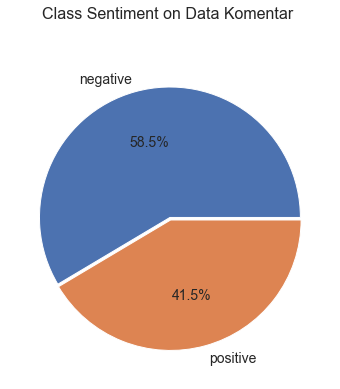

In [12]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in coments['sentimen'].value_counts()]
labels = list(coments['sentimen'].value_counts().index)
explode = (0.01, 0.01)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Class Sentiment on Data Komentar \n', fontsize = 16, pad = 20)
plt.show()

# Sentiment Analysis Using LSTM

## Preprocessing Text Data

In [13]:
# Make text preprocessed (tokenized) to untokenized with toSentence Function
X = coments['text_preprocessed'].apply(toSentence)
X

0                                      kurang guna materi
1                                          kontrak kuliah
2                                               ontime ya
3       papar materi diskus senang mata kuliah pancasi...
4                                hidup hari rinci masalah
                              ...                        
3553               kurang rangin tugas kringet dingin mis
3554             tambah bobot mata kuliah informasi tidak
3555                                  bapak jarang ngajar
3556                                          ajar jalan2
3557                      tidak kritik motivasi mahasiswa
Name: text_preprocessed, Length: 3551, dtype: object

In [14]:
max_features = 5000

# Tokenize text with specific maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)

X = tokenizer.texts_to_sequences(X.values)

X

[[3, 162, 2],
 [583, 8],
 [468, 59],
 [187, 2, 469, 31, 23, 8, 1065, 98],
 [39, 322, 470, 236],
 [85],
 [64, 13, 29, 222, 60],
 [31, 109, 1, 56, 34, 584],
 [21, 1066, 471, 402],
 [31],
 [2, 4, 2],
 [3, 585],
 [7, 16, 206, 1067, 5],
 [163, 148, 82, 2, 4, 44, 472],
 [4, 12, 1],
 [131, 61],
 [53, 1],
 [18, 1068, 35, 18, 59, 20],
 [35, 65, 734, 11, 19, 4],
 [1, 10, 4, 14, 735],
 [2, 23, 8],
 [1, 85],
 [188, 1],
 [3, 110, 164, 68],
 [1, 3, 99],
 [13, 62],
 [48, 2, 16, 9, 69, 32, 2, 1, 68, 66, 10, 20, 12],
 [70, 3, 9, 2],
 [76, 36, 1, 4, 1069, 36, 1, 403],
 [3, 132],
 [4, 29, 7, 1, 51, 93],
 [19, 2, 98, 6],
 [73, 1, 23, 8, 25, 3, 207],
 [1, 290],
 [27, 237, 5, 736],
 [19],
 [24, 32, 17, 26, 12, 94, 323],
 [1, 15, 2, 6],
 [238, 1, 17],
 [1, 75],
 [291, 208, 1070, 194, 1071],
 [1, 13, 239, 586, 36, 36],
 [61, 1],
 [3, 195, 11, 8],
 [3, 143, 258, 1, 292, 4, 6, 72],
 [13, 587],
 [165, 3, 41, 1, 2, 8],
 [95],
 [67, 473, 19, 5, 3, 9, 2],
 [7, 293, 294, 14, 11, 11],
 [26, 324, 7, 7, 196, 474],
 [13

In [15]:
X = pad_sequences(X)
X

array([[   0,    0,    0, ...,    3,  162,    2],
       [   0,    0,    0, ...,    0,  583,    8],
       [   0,    0,    0, ...,    0,  468,   59],
       ...,
       [   0,    0,    0, ...,   77,   33,   64],
       [   0,    0,    0, ...,    0,    1, 2309],
       [   0,    0,    0, ...,   14,  104,    5]])

In [16]:
X.shape

(3551, 34)

In [17]:
# Encode target data into numerical values
polarity_encode = {'negative' : 0, 'positive' : 1}
y = coments['sentimen'].map(polarity_encode).values

# Split the data (with composition data train 80%, data test 20%)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

## Model LSTM

In [18]:
# Create model function with default hyperparameter values

def create_model(embed_dim = 16, hidden_unit = 16, dropout_rate = 0.2, optimizers = Adam, learning_rate = 0.001):
    model = Sequential()
    model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X.shape[1]))
    model.add(LSTM(units = hidden_unit, activation = 'tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers(lr = learning_rate), metrics = ['accuracy'])
    print(model.summary())
    return model

In [19]:
# Results from hyperparameter tuning
results = pd.read_csv('data/gridsearchcv_results.csv')
results.sort_values(by='means', ascending = False).reset_index(drop=True)

,means,stds,params
0,0.916513,0.002494,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
1,0.916210,0.012881,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
2,0.915358,0.012066,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
3,0.915012,0.003830,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
4,0.912172,0.008714,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
...,...,...,...
283,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embe..."
284,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embe..."
285,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embe..."
286,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embe..."


In [20]:
# Create the model with the best hyperparameter which has been determined
model = KerasClassifier(build_fn = create_model,
                        # Model Parameters
                        dropout_rate = 0.2,
                        embed_dim = 32,
                        hidden_unit = 16,
                        optimizers = RMSprop,
                        learning_rate = 0.001,
                   
                        # Fit Parameters
                        epochs=10, 
                        batch_size=128,
                        # Initiate validation data, which is 10% data from data train. It's used for evaluation model
                        validation_split = 0.1)

In [21]:
scoring1 = ['accuracy', 'precision', 'recall', 'f1']

scoring = {'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average='macro'),
            'recall': make_scorer(recall_score, average='macro'),
            'f1': make_scorer(f1_score, average='macro')
            }

In [22]:
from sklearn.model_selection import cross_validate

cv_score = cross_validate(model, X, y, cv=5, scoring=scoring)
cv_score

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 34, 32)            160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2556 samples, validate on 284 samples
Epoch 1/10
2556/2556 [==============================] - 1s 308us/step - loss: 0.9172 - accuracy: 0.5739 - val_loss: 0.7453 - val_accuracy: 0.5775
Epoch 2/10
2556/2556 [==============================] - 0s 161us/step - loss: 0.7245 - accuracy: 0.5743 - val_loss: 0.6973 - val_accuracy: 0.5775
Epoch 3/10
2556/2556 [==============================] - 0s 160us/step - loss: 0.6888 - accuracy: 0.5982 - val_loss: 0.6689 - val_accuracy: 0.5775
Epoch 4/10
2556/2556 [==============================] - 0s 155us/step - loss: 0.6399 - accuracy: 0.6604 - val_loss: 0.6149 - val_accuracy: 0.7077
Epoch 5/10
2556/2556 [==============================] - 0s 154us/step - loss: 0.5564 - accuracy: 0.7938 - val_loss: 0.5493 - val_accuracy: 0.7570
Epoch 6/10
2556/2556 [==============================] - 0s 154us/step - loss: 0.4730 - accuracy: 0.8451 - val_loss: 0.4810 - val_accuracy: 0.8099
Epoch 7/10
2556/2556 [==============================] - 0s 151us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2556 samples, validate on 285 samples
Epoch 1/10
2556/2556 [==============================] - 1s 312us/step - loss: 0.9695 - accuracy: 0.5591 - val_loss: 0.8198 - val_accuracy: 0.5754
Epoch 2/10
2556/2556 [==============================] - 0s 162us/step - loss: 0.7603 - accuracy: 0.5865 - val_loss: 0.7026 - val_accuracy: 0.5754
Epoch 3/10
2556/2556 [==============================] - 0s 153us/step - loss: 0.6609 - accuracy: 0.6252 - val_loss: 0.6418 - val_accuracy: 0.5789
Epoch 4/10
2556/2556 [==============================] - 0s 146us/step - loss: 0.5710 - accuracy: 0.7418 - val_loss: 0.5642 - val_accuracy: 0.8211
Epoch 5/10
2556/2556 [==============================] - 0s 141us/step - loss: 0.4967 - accuracy: 0.8204 - val_loss: 0.4887 - val_accuracy: 0.8316
Epoch 6/10
2556/2556 [==============================] - 0s 142us/step - loss: 0.4285 - accuracy: 0.8541 - val_loss: 0.4510 - val_accuracy: 0.8421
Epoch 7/10
2556/2556 [==============================] - 0s 143us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2556 samples, validate on 285 samples
Epoch 1/10
2556/2556 [==============================] - 1s 295us/step - loss: 0.9362 - accuracy: 0.5540 - val_loss: 0.7656 - val_accuracy: 0.5754
Epoch 2/10
2556/2556 [==============================] - 0s 144us/step - loss: 0.7439 - accuracy: 0.5755 - val_loss: 0.7084 - val_accuracy: 0.5754
Epoch 3/10
2556/2556 [==============================] - 0s 141us/step - loss: 0.7021 - accuracy: 0.5935 - val_loss: 0.6775 - val_accuracy: 0.5754
Epoch 4/10
2556/2556 [==============================] - 0s 143us/step - loss: 0.6623 - accuracy: 0.6440 - val_loss: 0.6387 - val_accuracy: 0.7579
Epoch 5/10
2556/2556 [==============================] - 0s 141us/step - loss: 0.5885 - accuracy: 0.7570 - val_loss: 0.5662 - val_accuracy: 0.7789
Epoch 6/10
2556/2556 [==============================] - 0s 143us/step - loss: 0.5022 - accuracy: 0.8306 - val_loss: 0.5196 - val_accuracy: 0.7614
Epoch 7/10
2556/2556 [==============================] - 0s 142us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2556 samples, validate on 285 samples
Epoch 1/10
2556/2556 [==============================] - 1s 302us/step - loss: 0.9929 - accuracy: 0.5896 - val_loss: 0.8232 - val_accuracy: 0.6877
Epoch 2/10
2556/2556 [==============================] - 0s 162us/step - loss: 0.7223 - accuracy: 0.6514 - val_loss: 0.6464 - val_accuracy: 0.6561
Epoch 3/10
2556/2556 [==============================] - 0s 162us/step - loss: 0.5868 - accuracy: 0.7351 - val_loss: 0.5602 - val_accuracy: 0.8035
Epoch 4/10
2556/2556 [==============================] - 0s 163us/step - loss: 0.5281 - accuracy: 0.7696 - val_loss: 0.5320 - val_accuracy: 0.7509
Epoch 5/10
2556/2556 [==============================] - 0s 160us/step - loss: 0.4524 - accuracy: 0.8157 - val_loss: 0.4732 - val_accuracy: 0.8140
Epoch 6/10
2556/2556 [==============================] - 0s 162us/step - loss: 0.3964 - accuracy: 0.8502 - val_loss: 0.4288 - val_accuracy: 0.8246
Epoch 7/10
2556/2556 [==============================] - 0s 147us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2556 samples, validate on 285 samples
Epoch 1/10
2556/2556 [==============================] - 1s 321us/step - loss: 0.9675 - accuracy: 0.5689 - val_loss: 0.8065 - val_accuracy: 0.5930
Epoch 2/10
2556/2556 [==============================] - 0s 157us/step - loss: 0.7855 - accuracy: 0.5720 - val_loss: 0.7269 - val_accuracy: 0.5930
Epoch 3/10
2556/2556 [==============================] - 0s 151us/step - loss: 0.7194 - accuracy: 0.5978 - val_loss: 0.6730 - val_accuracy: 0.6070
Epoch 4/10
2556/2556 [==============================] - 0s 151us/step - loss: 0.6455 - accuracy: 0.6952 - val_loss: 0.6130 - val_accuracy: 0.6421
Epoch 5/10
2556/2556 [==============================] - 0s 152us/step - loss: 0.5679 - accuracy: 0.7746 - val_loss: 0.5443 - val_accuracy: 0.8070
Epoch 6/10
2556/2556 [==============================] - 0s 152us/step - loss: 0.5068 - accuracy: 0.8099 - val_loss: 0.5204 - val_accuracy: 0.8105
Epoch 7/10
2556/2556 [==============================] - 0s 153us/step - loss:

{'fit_time': array([5.47554779, 5.19342065, 5.15275574, 5.38170552, 5.55536294]),
 'score_time': array([0.15199924, 0.15399361, 0.15200686, 0.154001  , 0.15006733]),
 'test_accuracy': array([0.88748242, 0.86760563, 0.8943662 , 0.86197183, 0.86760563]),
 'test_precision': array([0.88200335, 0.86344538, 0.89015698, 0.8587384 , 0.86567286]),
 'test_recall': array([0.8921268 , 0.8766328 , 0.89139797, 0.86403562, 0.86301603]),
 'test_f1': array([0.88516515, 0.86554006, 0.89076004, 0.86037197, 0.86422707])}

In [23]:
cv_pred = cross_val_predict(model, X, y, cv=5)
print("Accuracy Score",accuracy_score(y, cv_pred))
print("Precision Score",precision_score(y, cv_pred, average='macro'))
print("Recall Score",recall_score(y, cv_pred, average='macro'))
print("F1 Score",f1_score(y, cv_pred, average='macro'))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 34, 32)            160000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 51        
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2556 samples, validate on 284 samples
Epoch 1/10
2556/2556 [==============================] - 1s 299us/step - loss: 0.9369 - accuracy: 0.4746 - val_loss: 0.7695 - val_accuracy: 0.6549
Epoch 2/10
2556/2556 [==============================] - 0s 154us/step - loss: 0.7391 - accuracy: 0.5806 - val_loss: 0.6926 - val_accuracy: 0.5775
Epoch 3/10
2556/2556 [==============================] - 0s 147us/step - loss: 0.6714 - accuracy: 0.6545 - val_loss: 0.6372 - val_accuracy: 0.6972
Epoch 4/10
2556/2556 [==============================] - 0s 149us/step - loss: 0.6020 - accuracy: 0.7238 - val_loss: 0.5762 - val_accuracy: 0.7676
Epoch 5/10
2556/2556 [==============================] - 0s 148us/step - loss: 0.5248 - accuracy: 0.7856 - val_loss: 0.5155 - val_accuracy: 0.7782
Epoch 6/10
2556/2556 [==============================] - 0s 144us/step - loss: 0.4484 - accuracy: 0.8353 - val_loss: 0.4635 - val_accuracy: 0.8169
Epoch 7/10
2556/2556 [==============================] - 0s 144us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2556 samples, validate on 285 samples
Epoch 1/10
2556/2556 [==============================] - 1s 285us/step - loss: 0.9814 - accuracy: 0.5591 - val_loss: 0.8055 - val_accuracy: 0.5754
Epoch 2/10
2556/2556 [==============================] - 0s 148us/step - loss: 0.7595 - accuracy: 0.5779 - val_loss: 0.7136 - val_accuracy: 0.5754
Epoch 3/10
2556/2556 [==============================] - 0s 147us/step - loss: 0.7151 - accuracy: 0.5806 - val_loss: 0.6819 - val_accuracy: 0.5754
Epoch 4/10
2556/2556 [==============================] - 0s 147us/step - loss: 0.6652 - accuracy: 0.6330 - val_loss: 0.6258 - val_accuracy: 0.7404
Epoch 5/10
2556/2556 [==============================] - 0s 145us/step - loss: 0.5771 - accuracy: 0.7606 - val_loss: 0.5475 - val_accuracy: 0.7719
Epoch 6/10
2556/2556 [==============================] - 0s 148us/step - loss: 0.4827 - accuracy: 0.8177 - val_loss: 0.4793 - val_accuracy: 0.7860
Epoch 7/10
2556/2556 [==============================] - 0s 148us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2556 samples, validate on 285 samples
Epoch 1/10
2556/2556 [==============================] - 1s 310us/step - loss: 1.0001 - accuracy: 0.5849 - val_loss: 0.8210 - val_accuracy: 0.5754
Epoch 2/10
2556/2556 [==============================] - 0s 159us/step - loss: 0.7310 - accuracy: 0.6264 - val_loss: 0.6700 - val_accuracy: 0.5754
Epoch 3/10
2556/2556 [==============================] - 0s 158us/step - loss: 0.6197 - accuracy: 0.7136 - val_loss: 0.5668 - val_accuracy: 0.7895
Epoch 4/10
2556/2556 [==============================] - 0s 152us/step - loss: 0.5068 - accuracy: 0.7954 - val_loss: 0.4900 - val_accuracy: 0.8105
Epoch 5/10
2556/2556 [==============================] - 0s 154us/step - loss: 0.4243 - accuracy: 0.8470 - val_loss: 0.4307 - val_accuracy: 0.8211
Epoch 6/10
2556/2556 [==============================] - 0s 153us/step - loss: 0.3631 - accuracy: 0.8764 - val_loss: 0.4070 - val_accuracy: 0.8491
Epoch 7/10
2556/2556 [==============================] - 0s 154us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2556 samples, validate on 285 samples
Epoch 1/10
2556/2556 [==============================] - 1s 302us/step - loss: 0.9239 - accuracy: 0.5732 - val_loss: 0.7567 - val_accuracy: 0.5754
Epoch 2/10
2556/2556 [==============================] - 0s 157us/step - loss: 0.7128 - accuracy: 0.6041 - val_loss: 0.6805 - val_accuracy: 0.6246
Epoch 3/10
2556/2556 [==============================] - 0s 158us/step - loss: 0.6411 - accuracy: 0.6635 - val_loss: 0.6054 - val_accuracy: 0.6877
Epoch 4/10
2556/2556 [==============================] - 0s 155us/step - loss: 0.5503 - accuracy: 0.7743 - val_loss: 0.5248 - val_accuracy: 0.8175
Epoch 5/10
2556/2556 [==============================] - 0s 155us/step - loss: 0.4560 - accuracy: 0.8455 - val_loss: 0.4589 - val_accuracy: 0.8246
Epoch 6/10
2556/2556 [==============================] - 0s 146us/step - loss: 0.3806 - accuracy: 0.8873 - val_loss: 0.4220 - val_accuracy: 0.8316
Epoch 7/10
2556/2556 [==============================] - 0s 148us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2556 samples, validate on 285 samples
Epoch 1/10
2556/2556 [==============================] - 1s 289us/step - loss: 0.9616 - accuracy: 0.5634 - val_loss: 0.7641 - val_accuracy: 0.5930
Epoch 2/10
2556/2556 [==============================] - 0s 144us/step - loss: 0.7526 - accuracy: 0.5599 - val_loss: 0.6987 - val_accuracy: 0.5930
Epoch 3/10
2556/2556 [==============================] - 0s 144us/step - loss: 0.6939 - accuracy: 0.6283 - val_loss: 0.6401 - val_accuracy: 0.6807
Epoch 4/10
2556/2556 [==============================] - 0s 147us/step - loss: 0.6012 - accuracy: 0.7387 - val_loss: 0.5640 - val_accuracy: 0.7649
Epoch 5/10
2556/2556 [==============================] - 0s 145us/step - loss: 0.5199 - accuracy: 0.8001 - val_loss: 0.5159 - val_accuracy: 0.8316
Epoch 6/10
2556/2556 [==============================] - 0s 143us/step - loss: 0.4523 - accuracy: 0.8435 - val_loss: 0.4436 - val_accuracy: 0.8246
Epoch 7/10
2556/2556 [==============================] - 0s 140us/step - loss:

In [24]:
print("Accuracy each fold :", cv_score['test_accuracy'])
print("Precision each fold :", cv_score['test_precision'])
print("Recall each fold :", cv_score['test_recall'])
print("F1 each fold :", cv_score['test_f1'])

Accuracy each fold : [0.88748242 0.86760563 0.8943662  0.86197183 0.86760563]
Precision each fold : [0.88200335 0.86344538 0.89015698 0.8587384  0.86567286]
Recall each fold : [0.8921268  0.8766328  0.89139797 0.86403562 0.86301603]
F1 each fold : [0.88516515 0.86554006 0.89076004 0.86037197 0.86422707]


In [25]:
cv_pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [26]:
conf_mat = confusion_matrix(y, cv_pred)
conf_mat

array([[1849,  230],
       [ 192, 1280]], dtype=int64)

In [27]:
print("Accuracy average :", cv_score['test_accuracy'].mean())
print("Precision average :", cv_score['test_precision'].mean())
print("Recall average :", cv_score['test_recall'].mean())
print("F1 average :", cv_score['test_f1'].mean())

Accuracy average : 0.8758063429805272
Precision average : 0.872003394698577
Recall average : 0.877441844750668
F1 average : 0.8732128557272055


In [28]:
print("Standard Deviation of Accuracy is % s " % (statistics.stdev(cv_score['test_accuracy'])))
print("Standard Deviation of Precision is % s " % (statistics.stdev(cv_score['test_precision'])))
print("Standard Deviation of Recall is % s " % (statistics.stdev(cv_score['test_recall'])))
print("Standard Deviation of F1 is % s " % (statistics.stdev(cv_score['test_f1'])))

Standard Deviation of Accuracy is 0.014201196484679119 
Standard Deviation of Precision is 0.0134054754215675 
Standard Deviation of Recall is 0.014132470266935728 
Standard Deviation of F1 is 0.013741049099543046 
